# Module

In [30]:
import warnings
warnings.filterwarnings(action='ignore')
import os
import sys
import dotenv
import nest_asyncio
dotenv.load_dotenv()
import requests
import json
from glob import glob
import time
import pandas as pd
from tqdm import tqdm
from urllib.parse import unquote
from collections import defaultdict
from bs4 import BeautifulSoup
from collections import Counter

# Setting

In [2]:
api_key = api_key = os.getenv("UPSTAGE_API_KEY")
file_name_list = glob("../data/nursing/*.pdf")
headers = {"Authorization": f"Bearer {api_key}"}
document_parser_url = "https://api.upstage.ai/v1/document-ai/async/document-parse"
document_parser_url_ = "https://api.upstage.ai/v1/document-ai/document-parse"
check_url = "https://api.upstage.ai/v1/document-ai/requests"


# Parsing

In [3]:
files = {"document": open("/home/livin/rag_pipeline/AutoRAG/data/test/nursing_test.pdf", "rb")}
data = {
    "ocr": "force",
    "output_formats": '["markdown", "html", "text"]'
    }
api_response = requests.post(document_parser_url_, headers=headers, files=files, data=data)

In [5]:
api_response.json()

{'api': '2.0',
 'content': {'html': '<header id=\'0\' style=\'font-size:18px\'>CHAPTER 14 호흡기장애 대상자 간호 I 553</header>\n<br><figure><img id=\'1\' alt="" data-coord="top-left:(1144,42); bottom-right:(1318,155)" /></figure>\n<h1 id=\'2\' style=\'font-size:20px\'>표 14-15 폐렴 대상자 간호</h1>\n<br><table id=\'3\' style=\'font-size:14px\'><tr><td>기대되는 결과</td><td>간호</td></tr><tr><td>비효과적인 호흡양상 개선 · 효과적으로 기침하고 호흡함 · 물을 3 L/일 마심 · 활력징후 정상 · 청진 시 폐음 정상 · 지시대로 물을 마심 · 객담을 잘 뱉어냄 · 소변색이 정상임</td><td>· 활력징후와 신체상태를 관찰한다. · 호흡의 횟수, 리듬, 깊이, 노력을 관찰한다. · 흉부의 움직임과 대칭 여부, 보조근의 사용, 쇄골 움직임, 늑간근 수축을 관찰한다. · 호흡양상을 관찰한다. 빈호흡, 빈맥, 과도환기, Kussmaul 호흡, Cheyne-Stokes 호흡, 지속성 흡식 (apneustic) 호흡, Biot 호흡, 실조성(ataxic) 호흡양상 등 · 횡격막의 근육피로를 관찰한다(paradoxical motion). · 호흡음을 청진하여 환기 감소나 결핍부위, 진통음(adventitions)이 틀리는 부위를 기록한다. · 악설음과 천명음을 청진하여 흡인이 필요한지 결정한다. · 동맥혈가스분석 결과를 확인하고, 안절부절못함, 불안 등의 산소부족 증상을 관찰한다. · 효과적인 기침 능력을 관찰한다: 기침의 시작, 특징, 기간 · 호흡기 분비물을 관찰한다. · 호흡곤란을 완화시키거나 악화시키는 요인을 확인한다. · 흉부 X-선 결과를 확인한다. · 심호흡으로 흉곽내 압력을 상승시켜 강하게 숨을

In [13]:
# document_file_name,request_id, download_url 이 컬럼인 df를 만들어서 csv로 저장 하는 로직 구현
df = []
for file_name in tqdm(file_name_list):
    try:
        print(f"{file_name} - Start!")
        files = {"document": open(file_name, "rb")}
        data = {
            "ocr": "force",
            "output_formats": '["markdown", "html", "text"]'
            }
        api_response = requests.post(document_parser_url, headers=headers, files=files, data=data)
        while True:
            check_response = requests.get(os.path.join(check_url, api_response.json()["request_id"]), headers=headers)
            is_completed = False
            for batch in check_response.json()["batches"]:
                if batch["status"] == "completed":
                    is_completed = True
                else:
                    is_completed = False
                    break
            if is_completed:
                print(f"{file_name} - Completed!")
                break
            else:
                time.sleep(10)
        for batch in check_response.json()["batches"]:
            df.append([file_name, api_response.json()["request_id"], batch])
        print(f"==============================================")
    except Exception as e:
        print(f"{file_name} - error")
        print(e)
        continue

# df를 csv로 저장
df = pd.DataFrame(df, columns=["document_file_name", "request_id", "batch"])
df.to_csv("../data/nursing/parse_result_test.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/livin/rag_pipeline/AutoRAG/data/test/nursing_test.pdf - Start!


100%|██████████| 1/1 [00:20<00:00, 20.61s/it]

/home/livin/rag_pipeline/AutoRAG/data/test/nursing_test.pdf - Completed!


# Check Result

##### Check request_id

In [8]:
check_response = requests.get(check_url, headers=headers).json()["requests"]

##### Downloading 함수 정의

In [25]:
def download_file(url, folder_path):
    # 폴더가 존재하지 않으면 생성
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # 파일 다운로드 시작
    response = requests.get(url, stream=True)
    response.raise_for_status()  # 다운로드가 실패했는지 확인

    file_name = url.split("/")[-1]
    # 파일명을 한글 인코딩을 고려하여 디코딩
    file_name = unquote(file_name).split("?")[0]


    # 저장 경로 지정
    file_path = os.path.join(folder_path, file_name)

    # 파일 저장
    with open(file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"File saved at {file_path}")


##### Downloading

In [ ]:
folder_path = "./downloads"

for check_response_i in check_response:
    if check_response_i["status"] == "completed":
        batch_results = requests.get(os.path.join(check_url, check_response_i["id"]), headers=headers).json()["batches"]
        for batch_result in batch_results:
            download_file(batch_result["download_url"], folder_path)
        print("Completed")
    else:
        print("Not completed yet")
        continue

# File Integration

##### html 파일로 저장

In [3]:
json_file_list = sorted(glob("../data/nursing/nursing_downloads/*"))
file_names = sorted(list(set([name.split(".pdf")[0].split("/")[-1] for name in name_list])))
file_name_to_json = defaultdict(list)

for file_name in file_names:
    for json_file in json_file_list:
        if file_name in json_file:
            file_name_to_json[file_name].append(json_file)

NameError: name 'name_list' is not defined

In [41]:
for file_name in file_name_to_json:
    file_corpus = ""
    for json_file in file_name_to_json[file_name]:
        with open(json_file, "r") as f:
            data_elements = json.load(f)
            for element in data_elements["elements"]:
                file_corpus += element["html"]
    # html 파일로 저장
    with open(f"../data/nursing/nursing_html/{file_name}.html", "w") as f:
        f.write(file_corpus)

##### corpus 파일로 변환 후 저장

In [54]:
df_dict = {"texts":[], "path":[], "page":[], "last_modified_datetime":[]}

In [55]:
for file_name in file_names:
    with open(f"../data/nursing/nursing_html/{file_name}.html", "r") as f:
        html = f.read()
        df_dict["texts"].append(html)
        df_dict["path"].append(file_name)
        df_dict["page"].append(-1)
        df_dict["last_modified_datetime"].append(pd.Timestamp.now())

In [56]:
df = pd.DataFrame(df_dict)

In [58]:
# csv 파일로 저장   
df.to_csv("../data/nursing/corpus/nursing_corpus.csv")

# parquet 파일로 저장   
df.to_parquet("../data/nursing/corpus/nursing_corpus.parquet")

In [6]:
# json 모듈로 파일을 읽기

import json
with open("/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_downloads/23장 내분비장애 대상자 간호.pdf_batch0002_0021_0030.json", "r") as f:
    data = json.load(f)

In [7]:
data

{'api': '1.1',
 'billed_pages': 10,
 'elements': [{'bounding_box': [{'x': 337, 'y': 116},
    {'x': 600, 'y': 116},
    {'x': 600, 'y': 142},
    {'x': 337, 'y': 142}],
   'category': 'header',
   'html': "<header id='0' style='font-size:16px'>UNIT 7 조정장애 대상자 간호</header>",
   'id': 0,
   'page': 21,
   'text': 'UNIT 7 조정장애 대상자 간호'},
  {'bounding_box': [{'x': 249, 'y': 116},
    {'x': 331, 'y': 116},
    {'x': 331, 'y': 143},
    {'x': 249, 'y': 143}],
   'category': 'paragraph',
   'html': "<br><p id='1' data-category='paragraph' style='font-size:18px'>566 I</p>",
   'id': 1,
   'page': 21,
   'text': '566 I'},
  {'bounding_box': [{'x': 185, 'y': 220},
    {'x': 416, 'y': 220},
    {'x': 416, 'y': 247},
    {'x': 185, 'y': 247}],
   'category': 'paragraph',
   'html': "<p id='2' data-category='paragraph' style='font-size:18px'>표 23-3 요붕증 치료약물</p>",
   'id': 2,
   'page': 21,
   'text': '표 23-3 요붕증 치료약물'},
  {'bounding_box': [{'x': 172, 'y': 235},
    {'x': 1186, 'y': 235},
    {'x': 11

# HTML Chunk to Text

In [40]:
# parquet 읽기
df = pd.read_parquet("../results/qa/nursing/corpus_text.parquet")

In [41]:
df["contents"][1230]

'파일 제목: 17장 혈액계 장애 대상자 간호\n 내용: 등\n을 발견할 수 있으며, 예후는 림프구, 혼합형, 조직구의\n순으로 나쁘다.\nWHO에서는 비호지킨림프종을 61개의 아형으로 분\n류하였으나 유전자의 발현 양상에 따라 모호한 저급과\n공격적인 고급 영역으로 분류한다.\nInternational Prognostic Index(IPI)는 각 유형별로 적\n합한 치료방법을 선택하도록 돕는다. 임상적 병기에 포\n함되는 요인은 림프절 외 병소의 수, 혈청 LDH, 백혈구\n수, 혈색소 수준, 연령과 일상생활 수행 정도이다.\n(3) 치료와 간호\n치료는 임상단계, 조직의 유형, 연령, 골수기능에 따\n라 다르다. I, II 단계와 같이 병소가 국한되었을 때 방\n사선치료를 실시한다. 병소가 진행되어 확산된 경우는\n방사선치료와 항암화학요법을 병용한다. III, IV 단계의\n림프종에는 항암화학요법을 실시한다.\n공격적인 림프종은 치료에 반응을 잘 하고 치유도 잘\n된다. 저급 림프종은 진행경과가 길지만 효과적으로 치\n료하기가 어렵다. Helicobacter pylori 위장림프종과 같\n이 감염으로 인한 경우는 항생제나 항바이러스제로 치\n료한다. 공격적이거나 난치성 일부 림프종은 말초 조혈\n모세포이식이 도움이 된다.\ncyclophosphamide(Cytoxan), vincristine sulfate,\nprednisone, procarbazine hydrochloride, doxorubicin\nhydrochloride와 bleomycin 등을 복합적으로 투여하거\n나 fludarabine과 단일 약제를 함께 투여한다. 재발한\n경우에는 monoclonal antibodies(예: rituximab과\nalemtuzumab, ibritumomab tiuxetan: Zevalin, tositu-\nmomab: Bexxar)와 radiolabeled antibodies, 즉 131I\ntositumomab와 90Y'

In [37]:
for i in range(len(df)):
    html_content = df["contents"][i]
    soup = BeautifulSoup(html_content, 'html.parser')
    df.iloc[i]["contents"] = soup.get_text(separator="\n")

In [38]:
df["contents"][1230]

'파일 제목: 17장 혈액계 장애 대상자 간호\n 내용: 등\n을 발견할 수 있으며, 예후는 림프구, 혼합형, 조직구의\n순으로 나쁘다.\nWHO에서는 비호지킨림프종을 61개의 아형으로 분\n류하였으나 유전자의 발현 양상에 따라 모호한 저급과\n공격적인 고급 영역으로 분류한다.\nInternational Prognostic Index(IPI)는 각 유형별로 적\n합한 치료방법을 선택하도록 돕는다. 임상적 병기에 포\n함되는 요인은 림프절 외 병소의 수, 혈청 LDH, 백혈구\n수, 혈색소 수준, 연령과 일상생활 수행 정도이다.\n(3) 치료와 간호\n치료는 임상단계, 조직의 유형, 연령, 골수기능에 따\n라 다르다. I, II 단계와 같이 병소가 국한되었을 때 방\n사선치료를 실시한다. 병소가 진행되어 확산된 경우는\n방사선치료와 항암화학요법을 병용한다. III, IV 단계의\n림프종에는 항암화학요법을 실시한다.\n공격적인 림프종은 치료에 반응을 잘 하고 치유도 잘\n된다. 저급 림프종은 진행경과가 길지만 효과적으로 치\n료하기가 어렵다. Helicobacter pylori 위장림프종과 같\n이 감염으로 인한 경우는 항생제나 항바이러스제로 치\n료한다. 공격적이거나 난치성 일부 림프종은 말초 조혈\n모세포이식이 도움이 된다.\ncyclophosphamide(Cytoxan), vincristine sulfate,\nprednisone, procarbazine hydrochloride, doxorubicin\nhydrochloride와 bleomycin 등을 복합적으로 투여하거\n나 fludarabine과 단일 약제를 함께 투여한다. 재발한\n경우에는 monoclonal antibodies(예: rituximab과\nalemtuzumab, ibritumomab tiuxetan: Zevalin, tositu-\nmomab: Bexxar)와 radiolabeled antibodies, 즉 131I\ntositumomab와 90Y'

In [39]:
# parquet 파일로 저장
df.to_parquet("../results/qa/nursing/corpus_text.parquet")

In [5]:
file_name, html_content = html_content.split("내용: ")

In [6]:
html_content

'<h1 id=\'0\' style=\'font-size:20px\'>강의용 자료파일 사용 안내</h1><p id=\'1\' data-category=\'list\' style=\'font-size:16px\'>1. 이 파일은 본 교재의 내용을 바탕으로 원활한<br>강의 진행에 도움을 드리고자 제작된 교수님<br>전용 파일입니다.<br>2. 해당 교과목 담당 교수님을 제외한 제3자에게<br>이 파일을 전송 및 배포(업로드/다운로드)하는<br>것을 금합니다.</p><footer id=\'2\' style=\'font-size:14px\'>의학/간호/보건 전문출판<br>Hyunmoon m 현문사</footer><h1 id=\'3\' style=\'font-size:18px\'>제8판</h1><br><h1 id=\'4\' style=\'font-size:22px\'>성인간호학 I 하권|</h1><br><p id=\'5\' data-category=\'paragraph\' style=\'font-size:16px\'>MEDICAL SURGICAL NURSING</p><br><p id=\'6\' data-category=\'paragraph\' style=\'font-size:14px\'>Eighth Edition</p><p id=\'7\' data-category=\'paragraph\' style=\'font-size:14px\'>대표저자 유양숙 권보은 김희경 박영례 박효미 안경주 엄미란 은 영 조경숙 최승혜</p><br><figure><img id=\'8\' style=\'font-size:20px\' alt="양 子\nIm 현문사" data-coord="top-left:(62,734); bottom-right:(1313,1715)" /></figure><p id=\'9\' data-category=\'paragraph\' style=\'font-size:18px\'>/unmo 현문사</p><p id=\'10\' data-category=\'paragraph\' 

In [9]:
soup = BeautifulSoup(html_content, 'html.parser')

In [10]:
text = soup.get_text(separator="\n")

In [11]:
text

'강의용 자료파일 사용 안내\n1. 이 파일은 본 교재의 내용을 바탕으로 원활한\n강의 진행에 도움을 드리고자 제작된 교수님\n전용 파일입니다.\n2. 해당 교과목 담당 교수님을 제외한 제3자에게\n이 파일을 전송 및 배포(업로드/다운로드)하는\n것을 금합니다.\n의학/간호/보건 전문출판\nHyunmoon m 현문사\n제8판\n성인간호학 I 하권|\nMEDICAL SURGICAL NURSING\nEighth Edition\n대표저자 유양숙 권보은 김희경 박영례 박효미 안경주 엄미란 은 영 조경숙 최승혜\n/unmo 현문사\n일러두기\n* 해부학용어는 대한의사협회 의학용어 4,5판에 근거하여 옛용어와 새용어를 병기하였으\n며, 질환명의 일부는 새용어를 소개하는 정도로 제시함\n* 본문 중 영문표기는 일반명사와 상품화된 약품명 등의 혼동을 우려해 고유명사와 상품\n명을 제외하고 모두 소문자로 표기함\n* 수술법이나 증상에 관한 부분은 설명으로 부족한 부분에 한하여 QR 코드를 제시하여 동\n영상을 바로 볼 수 있도록 함(동영상 주소는 변동 가능함)\n최근 코로나 팬데믹 상황으로 인하여 우리의 삶과 일상은 물론 교육환경도 많이 바뀌었습니다. 이론교육이\n온라인으로 이루어지고, 경험을 통해 배워야 하는 현장실습이 제한됨에'

In [13]:
result

'강의용 자료파일 사용 안내1. 이 파일은 본 교재의 내용을 바탕으로 원활한강의 진행에 도움을 드리고자 제작된 교수님전용 파일입니다.2. 해당 교과목 담당 교수님을 제외한 제3자에게이 파일을 전송 및 배포(업로드/다운로드)하는것을 금합니다.의학/간호/보건 전문출판Hyunmoon m 현문사제8판성인간호학 I 하권|MEDICAL SURGICAL NURSINGEighth Edition대표저자 유양숙 권보은 김희경 박영례 박효미 안경주 엄미란 은 영 조경숙 최승혜/unmo 현문사일러두기* 해부학용어는 대한의사협회 의학용어 4,5판에 근거하여 옛용어와 새용어를 병기하였으며, 질환명의 일부는 새용어를 소개하는 정도로 제시함* 본문 중 영문표기는 일반명사와 상품화된 약품명 등의 혼동을 우려해 고유명사와 상품명을 제외하고 모두 소문자로 표기함* 수술법이나 증상에 관한 부분은 설명으로 부족한 부분에 한하여 QR 코드를 제시하여 동영상을 바로 볼 수 있도록 함(동영상 주소는 변동 가능함)최근 코로나 팬데믹 상황으로 인하여 우리의 삶과 일상은 물론 교육환경도 많이 바뀌었습니다. 이론교육이'

In [42]:
from schema import Schema, And, Use

In [1]:
from glob import glob

In [2]:
paths = glob("/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/*html")

In [5]:
paths

['/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/25장 청각과 평형장애 대상자 간호.html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/22장 신경계장애 대상자간호-(1).html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/14장 호흡기장애 대상자 간호-(2).html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/24장 시각장애 대상자 간호.html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/30 판권.html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/15장 심장장애 대상자 간호-(2).html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/18장 요로계 장애 대상자 간호.html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/00 도입부(하권).html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/21장 근골격계 장애.html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/16장 혈관장애 대상자 간호.html',
 '/home/livin/rag_pip

In [7]:
"""
{
  "collection_name": "nursing_html_bgem3",
  "document_paths": [
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/25장 청각과 평형장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/22장 신경계장애 대상자간호-(1).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/14장 호흡기장애 대상자 간호-(2).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/24장 시각장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/30 판권.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/15장 심장장애 대상자 간호-(2).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/18장 요로계 장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/00 도입부(하권).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/21장 근골격계 장애.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/16장 혈관장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/26장 피부장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/19장 남성 생식기계 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/23장 내분비장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/22장 신경계장애 대상자간호-(2).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/15장 심장장애 대상자 간호-(1).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/20장 유방장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/17장 혈액계 장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/27장 화상간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/14장 호흡기장애 대상자 간호-(1).html"
  ],
  "chunk_size": 1024,
  "chunk_overlap": 200
}
"""

'\n{\n  "collection_name": "nursing_html_bgem3",\n  "document_paths": [\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/25장 청각과 평형장애 대상자 간호.html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/22장 신경계장애 대상자간호-(1).html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/14장 호흡기장애 대상자 간호-(2).html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/24장 시각장애 대상자 간호.html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/30 판권.html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/15장 심장장애 대상자 간호-(2).html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/18장 요로계 장애 대상자 간호.html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/00 도입부(하권).html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/21장 근골격계 장애.html",\n    "/home/l

In [2]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [4]:
with open("/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_json/14장 호흡기장애 대상자 간호-(1).json", "r") as f:
    result = json.load(f)

In [39]:
images = convert_from_path("/home/livin/rag_pipeline/AutoRAG/data/nursing/27장 화상간호.pdf", dpi=150)

In [22]:
idx = 30
image = images[idx]
width , height = image.size

In [40]:
##################################################
widths = []
heights = []
for i in images:
    widths.append(i.size[0])
    heights.append(i.size[1])
##################################################

In [41]:
Counter(widths), Counter(heights)

(Counter({1362: 28, 1575: 1}), Counter({1776: 28, 1181: 1}))

In [23]:
width, height

(2724, 3551)

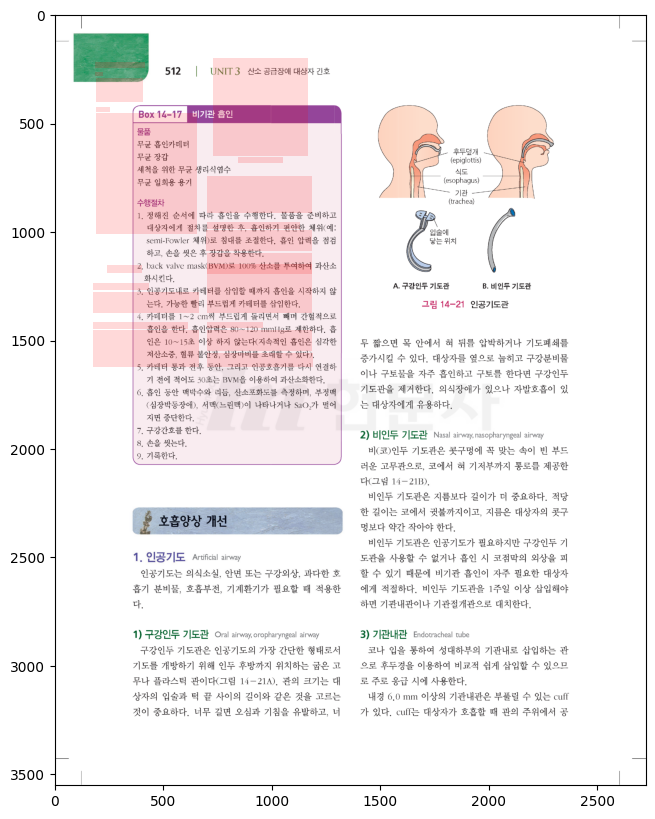

In [24]:
# image에 bounding box 그리기
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
for element in result["elements"]:
    if element["page"] == idx+1:
        # x = width*element["coordinates"][0]["x"]
        # y = height*element["coordinates"][0]["y"]
        # w = width*element["coordinates"][1]["x"] - width*element["coordinates"][0]["x"]
        # h = height*element["coordinates"][3]["y"] - height*element["coordinates"][0]["y"]
        x = element["bounding_box"][0]["x"]
        y = element["bounding_box"][0]["y"]
        w = element["bounding_box"][1]["x"] - element["bounding_box"][0]["x"]
        h = element["bounding_box"][3]["y"] - element["bounding_box"][0]["y"]

        rect = patches.Rectangle((x, y), w, h, linewidth=0, edgecolor='r', facecolor='r', alpha=0.15)
        ax.add_patch(rect)
plt.show()


In [57]:
a["elements"]

[{'category': 'header',
  'content': {'html': "<header id='0' style='font-size:18px'>CHAPTER 14 호흡기장애 대상자 간호 I 553</header>",
   'markdown': 'CHAPTER 14 호흡기장애 대상자 간호 I 553',
   'text': 'CHAPTER 14 호흡기장애 대상자 간호 I 553'},
  'coordinates': [{'x': 0.507, 'y': 0.0653},
   {'x': 0.813, 'y': 0.0653},
   {'x': 0.813, 'y': 0.0812},
   {'x': 0.507, 'y': 0.0812}],
  'id': 0,
  'page': 1},
 {'category': 'figure',
  'content': {'html': '<br><figure><img id=\'1\' alt="" data-coord="top-left:(1144,42); bottom-right:(1318,155)" /></figure>',
   'markdown': '',
   'text': ''},
  'coordinates': [{'x': 0.8404, 'y': 0.0239},
   {'x': 0.9677, 'y': 0.0239},
   {'x': 0.9677, 'y': 0.0875},
   {'x': 0.8404, 'y': 0.0875}],
  'id': 1,
  'page': 1},
 {'category': 'heading1',
  'content': {'html': "<h1 id='2' style='font-size:20px'>표 14-15 폐렴 대상자 간호</h1>",
   'markdown': '# 표 14-15 폐렴 대상자 간호',
   'text': '표 14-15 폐렴 대상자 간호'},
  'coordinates': [{'x': 0.1358, 'y': 0.1211},
   {'x': 0.3164, 'y': 0.1211},
   {'x': 0.31